# 1. 데이터 전처리

In [1]:
import pandas as pd

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

matplotlib.rc("axes", unicode_minus = False)

In [4]:
df = pd.read_csv("Car.csv")
df.head(3)

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh


In [5]:
# 수치형 값과 문자형 값을 구분
df[['Mileage_kmpl','Mileage']]= df['Mileage'].str.split(expand=True)
df[['Engine_CC','Engine']]= df['Engine'].str.split(expand=True)
df[['Power_bhp','Power']]= df['Power'].str.split(expand=True)
df[['New_Price_Lakh','New_Price']]= df['New_Price'].str.split(expand=True)

In [6]:
# 수치형 변수 float형으로 변환

df['Mileage_kmpl'] = df['Mileage_kmpl'].astype('float')
df['Engine_CC'] = df['Engine_CC'].astype('float')
df['Power_bhp'] = df['Power_bhp'].replace('null', np.nan)
df['Power_bhp'] = df['Power_bhp'].astype('float')

df['New_Price_Lakh'] = df['New_Price_Lakh'].replace('null', np.nan)
df['New_Price_Lakh'] = df['New_Price_Lakh'].astype('float')

In [7]:
# 문자형 값을 나타낸 열 제거

df.drop(columns=['Mileage','Engine','Power','New_Price'], inplace=True)

### 이상치, 결측치 확인 및 제거

In [8]:
df_train = df[df['Price'].notnull()]

In [9]:
df_train[df_train['Name']=='Honda City 1.5 GXI'] # 전체 데이터에서 모델명이 동일하면 좌석, 엔진, 파워 동일하게 채움
df_train.loc[df_train['Name']=='Honda City 1.5 GXI', 'Seats'] = 5.0
df_train.loc[df_train['Name']=='Honda City 1.5 GXI', 'Mileage_kmpl'] = 12.8
df_train.loc[df_train['Name']=='Honda City 1.5 GXI', 'Power_bhp'] = 100.0

In [10]:
df_train[df_train['Name']=='Toyota Etios Liva V'] # 전체 데이터에서 모델명이 동일하면 좌석, 엔진, 파워 동일하게 채움
df_train.loc[df_train['Name']=='Toyota Etios Liva V', 'Seats'] = 5.0
df_train.loc[(df_train['Name']=='Toyota Etios Liva V') & (df_train['Engine_CC'].isnull()), 'Engine_CC'] = round((1197.0*1.033),0) # 동일한 모델이지만 마일값이 1.03배 만큼 차이남
df_train.loc[(df_train['Name']=='Toyota Etios Liva V') & (df_train['Power_bhp'].isnull()), 'Power_bhp'] = round((78.9*1.033),1)        # 엔진, 파워도 1.03배 만큼 증가시킴

In [11]:
df_train[['Brand' , 'Name']] = df_train['Name'].str.split(n=1, expand=True)

In [12]:
df_train = df_train[df_train.groupby('Brand')['Brand'].transform('size') >= 50]
df_train = df_train[df_train.groupby('Year')['Year'].transform('size') >= 50]

In [13]:
# 같은 제조사의 같은 시리즈 명의 엔진, 좌석, 파워의 평균을 넣어준다.

# Swift_Mil_mean=df_train[df_train['Name'].str.contains('Swift')]['Mileage_kmpl'].mean()
Swift_Seat = df_train[df_train['Name'].str.contains('Swift')]['Seats'].mean() # 5밖에 없어서 5임
Swift_Engine_mean = df_train[df_train['Name'].str.contains('Swift')]['Engine_CC'].mean() # 평균들을 다 구해준다.
Swift_Power_mean = df_train[df_train['Name'].str.contains('Swift')]['Power_bhp'].mean()

In [14]:
df_train.loc[(df_train['Name'].str.contains('Swift')) & (df_train['Engine_CC'].isnull()), 'Engine_CC']= Swift_Engine_mean
df_train.loc[(df_train['Name'].str.contains('Swift')) & (df_train['Seats'].isnull()), 'Seats']= Swift_Seat
df_train.loc[(df_train['Name'].str.contains('Swift')) & (df_train['Power_bhp'].isnull()), 'Power_bhp']= Swift_Power_mean

In [15]:
# City 1.5 GXI 차량의 Engine 결측값 대체

df_train.loc[(df_train['Name'].str.contains('City 1.5 GXI')), 'Engine_CC'] = 1493.0

In [16]:
df_train.loc[(df_train['Name'].str.contains('5 Series 520d'))& (df_train['Engine_CC'].isnull()),'Engine_CC' ] = 1995.0
df_train.loc[(df_train['Name'].str.contains('5 Series 520d'))& (df_train['Power_bhp'].isnull()),'Power_bhp' ] = 190.00
df_train.loc[(df_train['Name'].str.contains('5 Series 520d'))& (df_train['Seats'].isnull()),'Seats' ] = 5.0

In [17]:
df_train.loc[(df_train['Name'].str.contains('Santro'))& (df_train['Engine_CC'].isnull()),'Engine_CC'] = 1086.0
df_train.loc[(df_train['Name'].str.contains('Santro'))& (df_train['Power_bhp'].isnull()),'Power_bhp'] = 62
df_train.loc[(df_train['Name'].str.contains('Santro'))& (df_train['Mileage_kmpl']==0),'Mileage_kmpl'] = 17.92

In [18]:
Swift_Seat = df_train[df_train['Name'].str.contains('Etios')]['Seats'].mode()[0] 
Swift_Engine_mean = df_train[df_train['Name'].str.contains('Etios')]['Engine_CC'].mean() # 평균들을 다 구해준다.
Swift_Power_mean = df_train[df_train['Name'].str.contains('Etios')]['Power_bhp'].mean()
Swift_Mil_mode = df_train[df_train['Name'].str.contains('Etios')]['Mileage_kmpl'].mode()[0]

df_train.loc[(df_train['Name'].str.contains('Etios')) & (df_train['Engine_CC'].isnull()), 'Engine_CC']= Swift_Engine_mean
df_train.loc[(df_train['Name'].str.contains('Etios')) & (df_train['Seats'].isnull()), 'Seats']= Swift_Seat
df_train.loc[(df_train['Name'].str.contains('Etios')) & (df_train['Power_bhp'].isnull()), 'Power_bhp']= Swift_Power_mean
df_train.loc[(df_train['Name'].str.contains('Etios')) & (df_train['Mileage_kmpl']==0), 'Mileage_kmpl']= Swift_Mil_mode

In [19]:
Swift_Seat = df_train[df_train['Name'].str.contains('Fiesta')]['Seats'].mode()[0] # 5밖에 없어서 5임
Swift_Engine_mean = df_train[df_train['Name'].str.contains('Fiesta')]['Engine_CC'].mean() # 평균들을 다 구해준다.
Swift_Power_mean = df_train[df_train['Name'].str.contains('Fiesta')]['Power_bhp'].mean()
Swift_Mil_mode = df_train[df_train['Name'].str.contains('Fiesta')]['Mileage_kmpl'].mode()[0]

df_train.loc[(df_train['Name'].str.contains('Fiesta')) & (df_train['Engine_CC'].isnull()), 'Engine_CC']= Swift_Engine_mean
df_train.loc[(df_train['Name'].str.contains('Fiesta')) & (df_train['Seats'].isnull()), 'Seats']= Swift_Seat
df_train.loc[(df_train['Name'].str.contains('Fiesta')) & (df_train['Power_bhp'].isnull()), 'Power_bhp']= Swift_Power_mean
df_train.loc[(df_train['Name'].str.contains('Fiesta')) & (df_train['Mileage_kmpl']==0), 'Mileage_kmpl']= Swift_Mil_mode

In [20]:
Swift_Seat = df_train[df_train['Name'].str.contains('Indica')]['Seats'].mode()[0] # 5밖에 없어서 5임
Swift_Engine_mean = df_train[df_train['Name'].str.contains('Indica')]['Engine_CC'].mean() # 평균들을 다 구해준다.
Swift_Power_mean = df_train[df_train['Name'].str.contains('Indica')]['Power_bhp'].mean()
Swift_Mil_mode = df_train[df_train['Name'].str.contains('Indica')]['Mileage_kmpl'].mode()[0]

df_train.loc[(df_train['Name'].str.contains('Indica')) & (df_train['Engine_CC'].isnull()), 'Engine_CC']= Swift_Engine_mean
df_train.loc[(df_train['Name'].str.contains('Indica')) & (df_train['Seats'].isnull()), 'Seats']= Swift_Seat
df_train.loc[(df_train['Name'].str.contains('Indica')) & (df_train['Power_bhp'].isnull()), 'Power_bhp']= Swift_Power_mean
df_train.loc[(df_train['Name'].str.contains('Indica')) & (df_train['Mileage_kmpl']==0), 'Mileage_kmpl']= Swift_Mil_mode

In [21]:
df_train = df_train.drop(df_train[df_train['Seats']==0].index) # seats가 0인 값 제거
df_train = df_train.drop(df_train[df_train['Mileage_kmpl']<5].index) # mileage <5 제거

In [22]:
df_train.drop(columns="New_Price_Lakh", inplace=True)
df_train.isnull().sum()
df_train.dropna(subset=['Price'], inplace=True)

In [23]:
df_train.dropna(subset="Power_bhp",inplace=True)
df_train['Seats'].fillna(df_train['Seats'].mode()[0], inplace=True) 
df_train.dropna(subset="Mileage_kmpl",inplace=True)

In [24]:
df_train.drop(df_train[df_train['Price']>160000].index, inplace=True) # 주행거리 이상치 제거
df_train.drop(columns="Name", inplace=True) # 이름 변수 제거
df_train.drop(df_train[df_train['Kilometers_Driven']>3000000].index, inplace=True) # 주행거리 이상치 제거

### 파생변수 추가

In [25]:
df_train.loc[df_train['Year']<=2012,'Year_cat'] = "2012이전"
df_train.loc[df_train['Year']>2012,'Year_cat'] = "2012이후"

In [26]:
df_train.loc[df_train['Engine_CC']<1000,'car_cat'] = "경차"
df_train.loc[(df_train['Engine_CC']>=1000) & (df_train['Engine_CC']<1600),'car_cat'] = "소형"
df_train.loc[(df_train['Engine_CC']>=1600) & (df_train['Engine_CC']<2000),'car_cat'] = "중형"
df_train.loc[df_train['Engine_CC']>=2000,'car_cat'] = "대형"

In [27]:
df_train['연식'] = 2020 - df_train['Year']
year_mean=df_train.groupby(['연식'])['Price'].mean().round(3).reset_index()
year_mean.columns = ['연식', '연식_mean']
df_train=pd.merge(df_train, year_mean, on="연식", how='left')

In [28]:
df_train.loc[(df_train['Kilometers_Driven']/df_train['연식'])>12000, '가성비']='bad'
df_train.loc[(df_train['Kilometers_Driven']/df_train['연식'])<=12000, '가성비']='good'

In [29]:
df_train.loc[(df_train['Mileage_kmpl']>=15), 'Mil_cat'] = '1등급' # 연비가 15이상이면 1등급
df_train.loc[(df_train['Mileage_kmpl']<15), 'Mil_cat'] = '2등급 이하' #연비가 15미만이면 2등급 이하

In [30]:
grouped = df_train.groupby('Mil_cat')['Price'].mean().round(3).reset_index() # 2개 등급으로 나눔
grouped.columns = ['Mil_cat', 'Mil_cat_mean']
 
df_train=pd.merge(df_train, grouped, on="Mil_cat", how='left')

In [31]:
# 경제 수준에 따라 구분

df_train.loc[df_train['Location']=='Mumbai', 'Location_cat'] = 'high'  
df_train.loc[df_train['Location']=='Hyderabad', 'Location_cat'] = 'high'

df_train.loc[df_train['Location']=='Coimbatore', 'Location_cat'] = 'medium'
df_train.loc[df_train['Location']=='Kochi', 'Location_cat'] = 'medium'
df_train.loc[df_train['Location']=='Pune', 'Location_cat'] = 'medium'
df_train.loc[df_train['Location']=='Delhi', 'Location_cat'] = 'medium'

df_train.loc[df_train['Location']=='Kolkata', 'Location_cat'] = 'low'
df_train.loc[df_train['Location']=='Chennai', 'Location_cat'] = 'low'
df_train.loc[df_train['Location']=='Jaipur', 'Location_cat'] = 'low'
df_train.loc[df_train['Location']=='Bangalore', 'Location_cat'] = 'low'
df_train.loc[df_train['Location']=='Ahmedabad', 'Location_cat'] = 'low'

df_train.loc[df_train['Seats']<= 5.0, 'Seats_5'] = '5 좌석'  # 좌석 5, 5미만, 5초과로 구분
df_train.loc[df_train['Seats'] > 5.0, 'Seats_5'] = '5 초과 좌석'
df_train.loc[df_train['Seats'] < 5.0, 'Seats_5'] = '5 미만 좌석'

df_train['new_Year'] = df_train['Year']  # 2010년도 이하 수치가 적어서 2010년 이하로 묶어서 new_Year변수 생성
df_train.loc[df_train['Year'] <= 2010, 'new_Year'] = '2010년 이하'

In [32]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor

In [33]:
df_x = df_train.drop(columns="Price")
df_y = df_train['Price']

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_numeric = df_x.select_dtypes(include="number")  # 숫자형 변수만 선택
df_x[df_numeric.columns] = scaler.fit_transform(df_x[df_numeric.columns])

In [35]:
df_raw_dummy = pd.get_dummies(df_x)
df_raw_y = df_y
df_raw_x = df_raw_dummy

In [36]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y
                                                                , test_size = 0.3, random_state = 1234) 

In [37]:
# xgb_model = xgb.XGBRegressor()

# # 탐색할 하이퍼파라미터 범위 설정
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 150, 200],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0, 0.1, 0.5]
# }

# # 그리드 서치를 사용하여 최적의 하이퍼파라미터 탐색
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
# grid_search.fit(df_train_x, df_train_y)

# # 최적의 하이퍼파라미터 출력
# print("Best parameters found: ", grid_search.best_params_)

# best_xgb_model = grid_search.best_estimator_
# train_pred = best_xgb_model.predict(df_train_x)
# test_pred = best_xgb_model.predict(df_test_x)

In [38]:
xgb_model = XGBRegressor(learning_rate=0.1,max_depth= 5,n_estimators= 200,reg_alpha= 0.1,reg_lambda= 0.5, random_state=1234)
xgb_model.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(xgb_model.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(xgb_model.score(df_test_x, df_test_y)))

Score on training set: 0.985
Score on test set: 0.865


In [39]:
rf_y_pred = xgb_model.predict(df_test_x)
print("MSE :",mean_squared_error(df_test_y, rf_y_pred))
print("RMSE :",mean_squared_error(df_test_y, rf_y_pred, squared=False))
print("MAE :",mean_absolute_error(df_test_y, rf_y_pred))

MSE : 34445908.715518564
RMSE : 5869.0637000733395
MAE : 2353.4212344405537


In [40]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = xgb_model.feature_importances_

# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
5,Power_bhp,0.294
0,Year,0.099
36,Brand_Land,0.045
24,Transmission_Automatic,0.043
60,Seats_5_5 좌석,0.041
...,...,...
8,Mil_cat_mean,0.000
25,Transmission_Manual,0.000
22,Fuel_Type_LPG,0.000
20,Fuel_Type_CNG,0.000


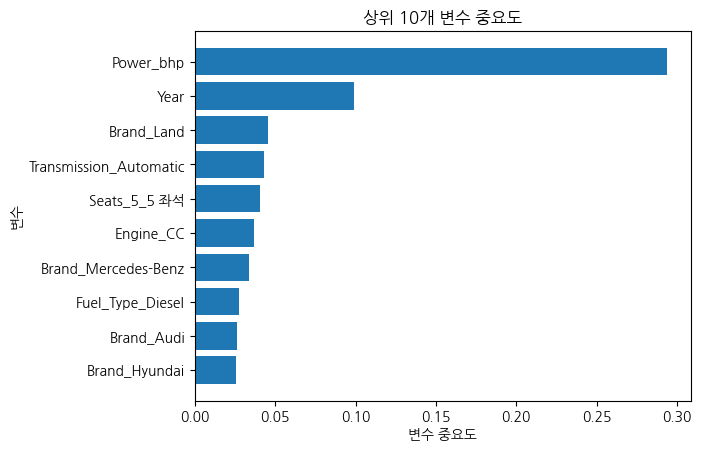

In [41]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = xgb_model.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
top_10_importance = df_importance.nlargest(10, "Importance")

# 시각화
coordinates = range(len(top_10_importance))
plt.barh(y=coordinates[::-1], width=top_10_importance["Importance"])
plt.yticks(coordinates[::-1], top_10_importance["Feature"], fontsize=10)
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.title("상위 10개 변수 중요도")
plt.show()

In [42]:
low_importance_variables = df_importance[df_importance["Importance"] ==0]["Feature"].tolist()

# df_train_x에서 중요도가 낮은 변수들을 제거
df_train_x_drop = df_train_x.drop(columns=low_importance_variables)
df_test_x_drop = df_test_x.drop(columns=low_importance_variables)

In [43]:
xgb_model = XGBRegressor(learning_rate=0.1,max_depth= 5,n_estimators= 200,reg_alpha= 0.1,reg_lambda= 0.5, random_state=1234)
xgb_model.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(xgb_model.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(xgb_model.score(df_test_x, df_test_y)))

rf_y_pred = xgb_model.predict(df_test_x)
print("MSE :",mean_squared_error(df_test_y, rf_y_pred))
print("RMSE :",mean_squared_error(df_test_y, rf_y_pred, squared=False))
print("MAE :",mean_absolute_error(df_test_y, rf_y_pred))

Score on training set: 0.985
Score on test set: 0.865
MSE : 34445908.715518564
RMSE : 5869.0637000733395
MAE : 2353.4212344405537
